# Title: NLP Model for Science Query Answering Using RNN

### Step 1: Import Necessary Libraries
- Import general-purpose libraries like NumPy and Pandas.

- Import TensorFlow and Keras for building and training the model.

- Import NLP libraries such as NLTK for text preprocessing.

- Import visualization tools such as Matplotlib and Seaborn for plotting.

In [10]:
# General Libraries
import numpy as np
import pandas as pd
import random
import re
import warnings

# NLP Processing (spaCy, NLTK, Transformers)
import nltk
from nltk.corpus import wordnet as wn
from transformers import GPT2Tokenizer

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# Data Augmentation & Preprocessing
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Warnings
warnings.filterwarnings("ignore")

print("All necessary imports loaded successfully!")

All necessary imports loaded successfully!


### Step 2: Load and Explore Dataset
- Load the dataset using Pandas.

- Display the first few rows to understand the structure.

- Check for missing values and handle them if necessary.

- Analyze basic statistics and data distribution.

In [20]:
import pandas as pd

# Define the path to your CSV file (Use raw string `r""` to avoid escape issues)
csv_file_path = r"C:\Users\user\Desktop\NYP Information Technology\IT3100 AI Application Project (AAP)\AI Project Model\Labelled Datasets\science_questions_labelled.csv"

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows and the total number of questions
print(df.head())
print(f"Total questions: {len(df)}")

                                            question  \
0  What type of organism is commonly used in prep...   
1  What phenomenon makes global winds blow northe...   
2  Changes from a less-ordered state to a more-or...   
3     What is the least dangerous radioactive decay?   
4  Kilauea in hawaii is the world’s most continuo...   

                        Topic  
0  Human Anatomy & Physiology  
1          Mechanics & Motion  
2          Physical Chemistry  
3          Mechanics & Motion  
4     Geology & Earth Science  
Total questions: 11578


### Step 3: Data Augmentation
- Apply synonym replacement using WordNet.

- Use back translation to generate paraphrased versions of the queries.

- Combine augmented data with the original dataset.

In [42]:
import random
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# **1️⃣ Synonym Replacement Function**
def replace_synonyms(sentence, prob=0.3):
    words = word_tokenize(sentence)
    new_sentence = []

    for word in words:
        if random.uniform(0, 1) < prob:  # Probability of replacement
            synonyms = wn.synsets(word)
            if synonyms:
                new_word = synonyms[0].lemmas()[0].name().replace("_", " ")  # Replace with first synonym
                new_sentence.append(new_word)
                continue
        new_sentence.append(word)

    return ' '.join(new_sentence)

# **2️⃣ Sentence Paraphrasing (Word Order Shuffle)**
def paraphrase_sentence(sentence):
    words = word_tokenize(sentence)  # Tokenize the sentence
    if len(words) > 3:
        random.shuffle(words)  # Shuffle words randomly
    return ' '.join(words)

# **Encode Labels (Refined_Category) for Multi-Class Classification**
label_encoder = LabelEncoder()
df["encoded_category"] = label_encoder.fit_transform(df["Topic"])  # Convert text labels to numbers

# **Apply augmentation: Generate multiple augmented versions while ensuring labels are correct**
augmented_data = []
augmented_labels = []

for question, label in zip(df["question"], df["encoded_category"]):
    synonym_replaced = replace_synonyms(question)  # Synonym replacement
    paraphrased = paraphrase_sentence(question)  # Sentence paraphrasing

    # Store original and augmented versions along with their labels
    augmented_data.append({"question": question, "augmented_question": question, "label": label})  # Original
    augmented_data.append({"question": question, "augmented_question": synonym_replaced, "label": label})  # Synonym replaced
    augmented_data.append({"question": question, "augmented_question": paraphrased, "label": label})  # Paraphrased version

# Convert to DataFrame
augmented_df = pd.DataFrame(augmented_data)

# **Convert labels to categorical (One-Hot Encoding)**
y = to_categorical(augmented_df["label"])  # One-hot encode labels

# **Display the number of rows before and after augmentation**
print(f"Original dataset size: {len(df)}")
print(f"Augmented dataset size: {len(augmented_df)} (3x original)")

# **Save the augmented dataset to CSV**
augmented_df.to_csv("augmented_science_questions_labelled.csv", index=False)

# **Display sample augmented questions with labels**
print(augmented_df.head(10))

Original dataset size: 11578
Augmented dataset size: 34734 (3x original)
                                            question  \
0  What type of organism is commonly used in prep...   
1  What type of organism is commonly used in prep...   
2  What type of organism is commonly used in prep...   
3  What phenomenon makes global winds blow northe...   
4  What phenomenon makes global winds blow northe...   
5  What phenomenon makes global winds blow northe...   
6  Changes from a less-ordered state to a more-or...   
7  Changes from a less-ordered state to a more-or...   
8  Changes from a less-ordered state to a more-or...   
9     What is the least dangerous radioactive decay?   

                                  augmented_question  label  
0  What type of organism is commonly used in prep...      7  
1  What type of organism be commonly used in prep...      7  
2  preparation organism yogurt What such is foods...      7  
3  What phenomenon makes global winds blow northe...     10  


### Step 4: Tokenization and Padding
- Fit a Hugging Face tokenizer on the text data.

- Pad sequences to ensure uniform input size.

In [43]:
from transformers import GPT2Tokenizer
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Tokenize augmented questions
augmented_df["tokenized_question"] = augmented_df["augmented_question"].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=128, add_special_tokens=True)
)

# **Save the augmented and tokenized dataset to CSV**
augmented_df.to_csv("augmented_science_questions_tokenized.csv", index=False)

# **Display sample augmented and tokenized questions**
print(augmented_df.head(10))

                                            question  \
0  What type of organism is commonly used in prep...   
1  What type of organism is commonly used in prep...   
2  What type of organism is commonly used in prep...   
3  What phenomenon makes global winds blow northe...   
4  What phenomenon makes global winds blow northe...   
5  What phenomenon makes global winds blow northe...   
6  Changes from a less-ordered state to a more-or...   
7  Changes from a less-ordered state to a more-or...   
8  Changes from a less-ordered state to a more-or...   
9     What is the least dangerous radioactive decay?   

                                  augmented_question  label  \
0  What type of organism is commonly used in prep...      7   
1  What type of organism be commonly used in prep...      7   
2  preparation organism yogurt What such is foods...      7   
3  What phenomenon makes global winds blow northe...     10   
4  What phenomenon brand global winds blow northe...     10   
5  he

### Step 5:

In [44]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode Labels (Refined_Category) for Multi-Class Classification
label_encoder = LabelEncoder()
df["encoded_category"] = label_encoder.fit_transform(df["Topic"])  # Convert text labels to numbers

# Convert to Categorical (One-Hot Encoding for Multi-Class Classification)
y = to_categorical(df["encoded_category"])

# Print shape to confirm
print(f"Shape of y: {y.shape}")  # Should be (num_samples, num_classes)

Shape of y: (11578, 18)


### Step 6: Define the RNN Model
- Add an embedding layer for word representations.

- Include LSTM layers for sequential processing.

- Add dropout layers to prevent overfitting.

- Use dense layers for classification or keyword identification.

In [45]:
# Build RNN Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define max_sequence_length (if not already defined)
max_sequence_length = 128  # You can adjust this as needed

# Get vocab size from GPT-2 tokenizer
vocab_size = tokenizer.vocab_size  # GPT-2 tokenizer vocabulary size

# Build Adjusted RNN Model
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=128, input_length=max_sequence_length),
    
    # First Bidirectional LSTM Layer
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-2))),
    BatchNormalization(),
    Dense(64, activation='relu'),  
    Dropout(0.3),

    # Second Bidirectional LSTM Layer
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(1e-2))),
    BatchNormalization(),
    Dense(32, activation='relu'),  
    Dropout(0.3),

    # Fully Connected Layer
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    
    # Output Layer
    Dense(y.shape[1], activation='softmax')  # Multi-class classification
])

### Step 7: Compile the Model
- Select an optimizer (e.g., Adam).

- Define the appropriate loss function, categorical crossentrophy.

- Specify evaluation metrics which is accuracy.

In [46]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

### Step 8: Data Splitting
- Split the dataset into training and testing subsets.

- Ensure the split maintains class distribution.

- Separate the features and labels for both sets.

In [65]:
from sklearn.model_selection import train_test_split

# Define X as the tokenized sequences
X = augmented_df["tokenized_question"].tolist()  # Convert tokenized questions to a list

# Convert to numpy array (ensures compatibility with TensorFlow/Keras)
import numpy as np
X = np.array(X, dtype=object)

# Repeat each label 3 times to match augmentation (original + 2 augmented versions)
y_expanded = np.repeat(y, 3, axis=0)  # Ensures y is tripled

# Ensure correct shape
print(f"Shape of X: {len(X)}, Shape of y: {len(y_expanded)}") 

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y_expanded, test_size=0.2, random_state=42, stratify=y_expanded)

# Display Split Info
print(f"Training samples: {len(X_train)}, Labels: {len(y_train)}")
print(f"Testing samples: {len(X_test)}, Labels: {len(y_test)}")

Shape of X: 34734, Shape of y: 34734
Training samples: 27787, Labels: 27787
Testing samples: 6947, Labels: 6947


### Step 9: Train the Model
- Define the number of epochs and batch size.

- Train the model using the training data.

- Monitor validation loss and accuracy during training.

- Apply early stopping to stop training when validation performance stops improving.

In [66]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure X_train and X_test are padded to a fixed length
max_sequence_length = 128  # Use same max length as during tokenization
X_train_padded = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss instead of accuracy
    patience=5,  # Stop if validation loss doesn't improve for 5 epochs
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=30,
    batch_size=128,
    callbacks=[early_stopping]
)

# Print completion message
print("Training complete!")

Epoch 1/30
218/218 [==============================] - 53s 245ms/step - loss: 0.1457 - accuracy: 0.9775 - val_loss: 1.8578 - val_accuracy: 0.7076
Epoch 2/30
218/218 [==============================] - 53s 245ms/step - loss: 0.1137 - accuracy: 0.9846 - val_loss: 0.1169 - val_accuracy: 0.9830
Epoch 3/30
218/218 [==============================] - 54s 248ms/step - loss: 0.1265 - accuracy: 0.9815 - val_loss: 3.6933 - val_accuracy: 0.4907
Epoch 4/30
218/218 [==============================] - 54s 248ms/step - loss: 0.1078 - accuracy: 0.9869 - val_loss: 0.2421 - val_accuracy: 0.9404
Epoch 5/30
218/218 [==============================] - 54s 248ms/step - loss: 0.0791 - accuracy: 0.9908 - val_loss: 0.7677 - val_accuracy: 0.8221
Epoch 6/30
218/218 [==============================] - 54s 249ms/step - loss: 0.0754 - accuracy: 0.9910 - val_loss: 0.1013 - val_accuracy: 0.9833
Epoch 7/30
218/218 [==============================] - 55s 250ms/step - loss: 0.0783 - accuracy: 0.9911 - val_loss: 0.2481 - val_ac

### Step 10: Save the Model
- Save the model architecture and weights to a file.

In [67]:
model.save('science_nlp_rnn_model.h5')

### Step 11: Evaluate the Model
- Load the test dataset.

- Evaluate the model’s performance on the test data.

- Compute evaluation metrics such as precision, recall, and F1-score.

In [68]:
# Evaluate Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure X_test is padded (same as during training)
max_sequence_length = 128  # Should be the same as in model training
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

218/218 [==============================] - 11s 50ms/step - loss: 0.0725 - accuracy: 0.9898
Test Loss: 0.0725349485874176
Test Accuracy: 0.9897797703742981


### Step 12: Test with New Queries
- Load the test dataset.

- Evaluate the model’s performance on the test data.

- Compute evaluation metrics such as precision, recall, and F1-score.

In [69]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define new queries for testing
new_queries = [
    "State and explain Newton’s second law of motion.",  # Mechanics & Motion
    "Describe how an electric motor works using electromagnetic induction.",  # Electricity & Magnetism
    "Explain how the Doppler effect applies to sound waves and light waves.",  # Waves & Optics
    "How does Le Chatelier’s principle explain shifts in chemical equilibrium?",  # Physical Chemistry
    "Describe how DNA replication ensures genetic continuity in cell division.",  # Genetics & Evolution
    "What is the role of decomposers in an ecosystem's nutrient cycle?",  # Ecology & Environmental Biology
    "Explain how climate change influences the frequency of extreme weather events.",  # Physical Geography
]

# Tokenize new queries
new_sequences = [
    tokenizer.encode(q, truncation=True, max_length=max_sequence_length, add_special_tokens=True) 
    for q in new_queries
]

# Pad sequences to match model input shape
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Predict using the trained model
predictions = model.predict(new_padded, verbose=0)

# Decode Predictions to Class Labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Print Results
print("\n🔹 Model Predictions:")
for query, label in zip(new_queries, predicted_labels):
    print(f"Query: {query}\nPredicted Category: {label}\n{'-'*50}")


🔹 Model Predictions:
Query: State and explain Newton’s second law of motion.
Predicted Category: Mechanics & Motion
--------------------------------------------------
Query: Describe how an electric motor works using electromagnetic induction.
Predicted Category: Electricity & Magnetism
--------------------------------------------------
Query: Explain how the Doppler effect applies to sound waves and light waves.
Predicted Category: Waves & Optics
--------------------------------------------------
Query: How does Le Chatelier’s principle explain shifts in chemical equilibrium?
Predicted Category: Physical Chemistry
--------------------------------------------------
Query: Describe how DNA replication ensures genetic continuity in cell division.
Predicted Category: Genetics & Evolution
--------------------------------------------------
Query: What is the role of decomposers in an ecosystem's nutrient cycle?
Predicted Category: Ecology & Environmental Biology
---------------------------

### Step 13: Visualize Results
- Plot training and validation accuracy and loss.

- Generate a confusion matrix for test predictions.

- Visualize metrics like precision and recall.

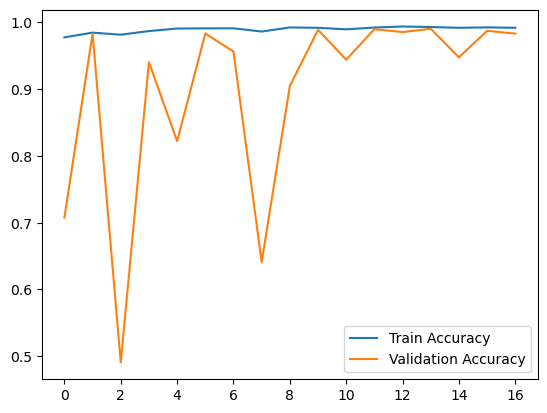

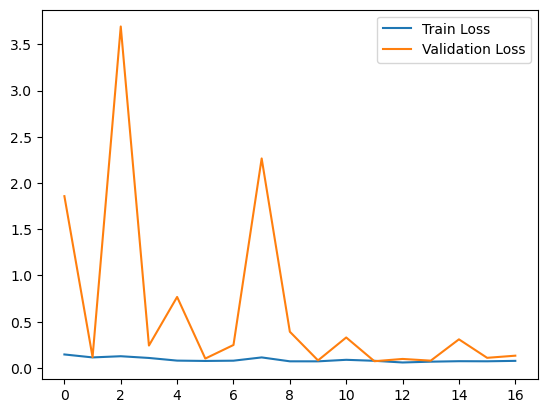

In [70]:
# Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

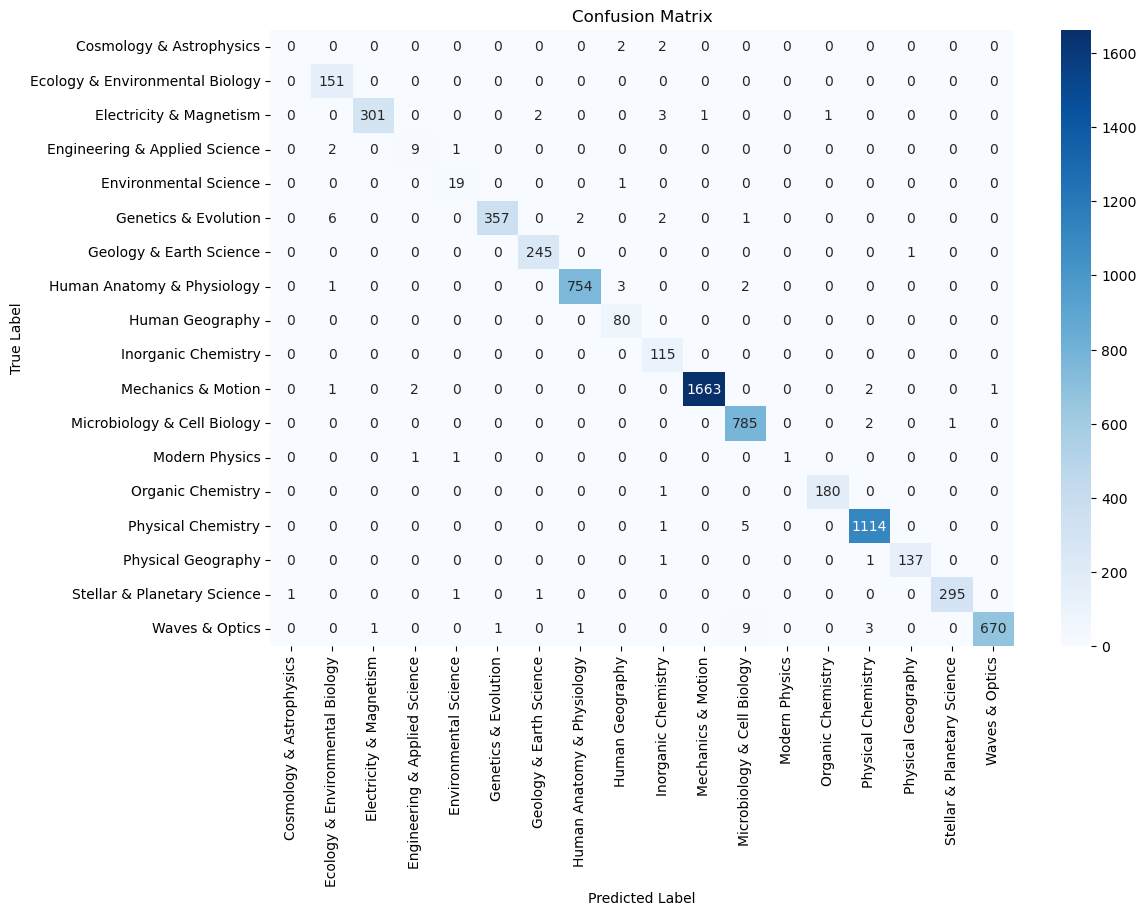


🔹 Classification Report:

                                 precision    recall  f1-score   support

       Cosmology & Astrophysics       0.00      0.00      0.00         4
Ecology & Environmental Biology       0.94      1.00      0.97       151
        Electricity & Magnetism       1.00      0.98      0.99       308
  Engineering & Applied Science       0.75      0.75      0.75        12
          Environmental Science       0.86      0.95      0.90        20
           Genetics & Evolution       1.00      0.97      0.98       368
        Geology & Earth Science       0.99      1.00      0.99       246
     Human Anatomy & Physiology       1.00      0.99      0.99       760
                Human Geography       0.93      1.00      0.96        80
            Inorganic Chemistry       0.92      1.00      0.96       115
             Mechanics & Motion       1.00      1.00      1.00      1669
    Microbiology & Cell Biology       0.98      1.00      0.99       788
                 Modern

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Ensure X_test is padded before evaluation
X_test_padded = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

# Predict class probabilities
y_pred_probs = model.predict(X_test_padded, verbose=0)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)  # Model predictions
y_true = np.argmax(y_test, axis=1)  # True labels (since y_test is one-hot encoded)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate Precision, Recall, and F1-Score
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("\n🔹 Classification Report:\n")
print(report)